## supervised learning with extra feature engineering

whats new: 


instead of use total complaints for each company from whole dataset (data leakage of future info), generated the following features:

- number of the company's last 90 days complaints
- number of the company's last 90 days disputes
- ratio of the company's last 90 days disputes to the company's last 90 days total complaints (we hypothesize that the higher the ratio, the more likely it is to be disputed)
- word count of each complaint narrative (we hypothesize that the more words a complaint has, the more likely it is to be disputed)
- days between date received and date sent to company (we hypothesize that the longer it takes for the company to respond, the more likely it is to be disputed because the responsiveness)  

these features are not data leakage, because they are calculated from the entry's relative days, historical data at each specific time point,
not from the whole dataset. 

They encode the company's recent performance, e.g the ratio could be be indicator of the company's future performance.

We also found that use TF-IDF features to alone, in this case perform better than previous use word2vec features alone, or TF-IDF weighting word2vec features.
And we limited the TF-IDF features to 5000 D, to reduce the dimensionality instead of using all 90000+ features / dimensions.

There were other ideas, but has not test the score in full set yet, e.g.:
- Combine 'Product' and 'Sub-product' to one feature
- Combine 'Issue' and 'Sub-issue' to one feature
by doing so, we could reduce the dimensionality of the categorical features, and also reduce the sparsity of the data. @todo next




In [1]:
# Built-in libraries
import re
import string
import warnings

# Third-party libraries for data handling and processing
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from gensim.models import KeyedVectors

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Pre-processing
from imblearn.over_sampling import SMOTE


# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Miscellaneous
stop_words = set(stopwords.words('english'))
tqdm.pandas()
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set the seed for reproducible results
np.random.seed(42)

# Load from google drive

# from google.colab import drive
# drive.mount('/content/drive')

[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>


In [2]:
# google: '/content/drive/My Drive/Colab Notebooks/assets/'

file01 = 'complaints.csv'
# file02 = 'GoogleNews-vectors-negative300.bin.gz'
# file01 = '/content/drive/My Drive/Colab Notebooks/assets/complaints.csv'
# file02 = '/content/drive/My Drive/Colab Notebooks/assets/GoogleNews-vectors-negative300.bin.gz'

df = pd.read_csv(file01)

# EMBEDDING = KeyedVectors.load_word2vec_format(file02, binary=True)

df.shape

(4028530, 18)

In [3]:
# preprocess the narrative column
def preprocess_narrative(text):
    # Lowercase
    text = text.lower()

    # Remove XXXX like pattern
    text = re.sub(r'x{2,}', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces
    text = text.strip()

    return text


# # define a function get mean word2vec vector for a narrative
# def get_mean_word2vec(word2vec, narrative):
# 
#     # initialize vector
#     vector = np.zeros(300)
# 
#     # get all words in narrative
#     words = narrative.split()
#     num_words = len(words)
# 
#     if num_words == 0:  # edge case: empty narrative
#         return vector
# 
#     # calculate word vectors using list comprehension
#     word_vectors = [word2vec[word] for word in words if word in word2vec]
# 
#     if word_vectors:
#         vector = np.mean(word_vectors, axis=0)
# 
#     return vector


# define a function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):

    print("Training the model...\n")
    # print model name
    print(model.__class__.__name__)

    # train the model
    model.fit(X_train, y_train)

    # predict on test data
    y_pred = model.predict(X_test)

    # print f1 score
    print("\nF1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
    print()

    # print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()

    # print classification report
    # print("Classification Report:")
    # print(classification_report(y_test, y_pred))

    print(f"-------------------------\n")

    return model


In [4]:
# drop rows with missing values on narrative column and dispute column
df.dropna(subset=['Consumer complaint narrative', 'Consumer disputed?'], inplace=True)

In [5]:
# sample 50% of the data for faster training and demostration purpose

# df = df.sample(frac=0.5, random_state=42)

In [6]:
# preprocess the narrative column
df['narrative_clean'] = df['Consumer complaint narrative'].progress_apply(preprocess_narrative)

# save to a variable of narrative_clean as numpy array
narrative_clean = df['narrative_clean'].values


100%|██████████| 164034/164034 [00:17<00:00, 9158.09it/s] 


In [7]:
# encode target variable
df['Consumer disputed?'] = df['Consumer disputed?'].map({'Yes': 1, 'No': 0})

y = df['Consumer disputed?'].values

### Feature Engineering: days between date received and date sent to company

In [8]:
# feature engineering: days between date received and date sent to company

# convert date received and date sent to company to datetime
df['Date received'] = pd.to_datetime(df['Date received'])
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

# calculate days between date received and date sent to company
df['days_between'] = (df['Date sent to company'] - df['Date received']).dt.days

# int
df['days_between'] = df['days_between'].astype(int)

# fill with 0 for any negative values
df['days_between'] = df['days_between'].apply(lambda x: 0 if x < 0 else x)

### Feature Engineering: number of words in complaint narrative

In [9]:
# feature engineering: number of words in narrative (on original narrative column)

# get number of words in narrative

df['narrative_word_count'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))

### Feature Engineering: number of disputed for the company in the last 90 days

In [11]:
# feature engineering: 
# For each row, calculate the number of disputed for that company in the last 90 days
# Define the lambda expression to compute disputed count for each row

df["Disputed_count_last_90_days"] = df.progress_apply(
    lambda row: df[
        (df["Date received"] <= row["Date received"]) &
        (df["Date received"] > (row["Date received"] - pd.Timedelta(days=90))) &
        (df["Company"] == row["Company"]) &
        (df["Consumer disputed?"] == 1)
    ].shape[0],
    axis=1
)

100%|██████████| 164034/164034 [38:28<00:00, 71.04it/s]


### Feature Engineering: number of complaints for the company in the last 90 days

In [12]:
# feature engineering:
# For each row, calculate the number of complaints for that company in the last 90 days
df["Complaints_last_90_days"] = df.progress_apply(
    lambda row: df[
        (df["Date received"] <= row["Date received"]) &
        (df["Date received"] > (row["Date received"] - pd.Timedelta(days=90))) &
        (df["Company"] == row["Company"])
    ].shape[0],
    axis=1
)

100%|██████████| 164034/164034 [40:58<00:00, 66.71it/s]


### Feature Engineering: ratio. Rate of disputed

In [13]:
# feature engineering: 
# ratio of number of disputed in the last 90 days / number of complaints in the last 90 days

df['Disputed_ratio_last_90_days'] = df['Disputed_count_last_90_days'] / df['Complaints_last_90_days']

#### Vectorize narrative_clean text to TF-IDF features 5000 Features/Dimensions

In [14]:
# TF-IDF features 5000 D to vectorize narrative_clean text

# initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# fit and transform using tfidf vectorizer
tfidf_vectorizer.fit(narrative_clean)

X_tfidf = tfidf_vectorizer.transform(narrative_clean)

#### Drop columns logic

In [16]:
# drop columns
# 1. date received (computed to days between, redundant)
# 2. date sent to company (computed to days between, redundant)
# 3. consumer complaint narrative (already vectorized to tfidf features)
# 4. complaint ID (unique identifier, not useful for modeling)
# 5. timely response? (highly skewed, 99-1, not useful for modeling
# 6. consumer consent provided? (only one value, no variance not useful for modeling)
# 7. submitted via (only one value, no variance not useful for modeling)
# 8. narrative_clean (already vectorized to tfidf features)
# 9. zip code (high cardinality, would expand almost 7000 dimension if included. likely correlate with State)
# 10. consumer disputed? (remove target variable)

drop_cols = [
    'Date received', 
    'Date sent to company', 
    'Consumer complaint narrative', 
    'Complaint ID', 
    'Timely response?', 
    'Consumer consent provided?', 
    'Submitted via',
    'narrative_clean',
    'ZIP code',
    'Consumer disputed?',
]

df.drop(drop_cols, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164034 entries, 31338 to 4028159
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Product                       164034 non-null  object 
 1   Sub-product                   111863 non-null  object 
 2   Issue                         164034 non-null  object 
 3   Sub-issue                     83055 non-null   object 
 4   Company public response       78122 non-null   object 
 5   Company                       164034 non-null  object 
 6   State                         163575 non-null  object 
 7   Tags                          26994 non-null   object 
 8   Company response to consumer  164034 non-null  object 
 9   days_between                  164034 non-null  int64  
 10  narrative_word_count          164034 non-null  int64  
 11  Disputed_count_last_90_days   164034 non-null  int64  
 12  Complaints_last_90_days       164034 non-nul

In [17]:
df.isna().sum()

Product                              0
Sub-product                      52171
Issue                                0
Sub-issue                        80979
Company public response          85912
Company                              0
State                              459
Tags                            137040
Company response to consumer         0
days_between                         0
narrative_word_count                 0
Disputed_count_last_90_days          0
Complaints_last_90_days              0
Disputed_ratio_last_90_days          0
dtype: int64

In [18]:
# fill na with 'Unknown'
df.fillna('Unknown', inplace=True)

#### One hot encode categorical features

In [19]:
# one hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

#### Concatenate TF-IDF features and encoded dataframe
5000 D + 3435 D = 8435 (features/dimensions)

In [21]:
# concat df with X_bow and df.values
X = np.concatenate((X_tfidf.toarray(), df.values), axis=1)

#### Exporting cleaned and manipulated data to csv for reusability and avoid re-run the whole notebook

In [29]:
# Exporting cleaned and manipulated data to csv
# save X and y for future use. 
# (ready-to-train data and target)

# tfidf feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# feature name of dataframe
feature_names = np.concatenate((tfidf_feature_names, df.columns))

# assign feature_names to be columns of X, create a dataframe call data_X
data_X = pd.DataFrame(X, columns=feature_names)

# save data_X to csv
data_X.to_csv('data_X.csv', index=False)

# save y to csv
pd.DataFrame(y).to_csv('y.csv', index=False)

# del data_X
del data_X

In [30]:
# print shape of X and y
print(X.shape, y.shape)


(164034, 8435) (164034,)


In [ ]:
# to restore, do the following:

# data_X = pd.read_csv('data_X.csv')
# y = pd.read_csv('y.csv')

# files download:
# https://www.dropbox.com/s/o5bzp4wscgmfy7v/data_X.csv.zip?dl=0
# https://www.dropbox.com/s/ekmpti8mj4eds1e/y.csv.zip?dl=0

# then continue flow below. 

#### Imbalance Handling

In [22]:
# smote to handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# shape
print(X_smote.shape, y_smote.shape)

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# shape
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(205163, 8435) (205163,) (51291, 8435) (51291,)


### Machine Learning: Fitting and Evaluating Various Models

In [24]:
# fit lightgbm
lbbm = train_evaluate_model(LGBMClassifier(random_state=42), X_train, y_train, X_test, y_test)

Training the model...

LGBMClassifier
[LightGBM] [Info] Number of positive: 102570, number of negative: 102593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.010346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1064360
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 6142
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499944 -> initscore=-0.000224
[LightGBM] [Info] Start training from score -0.000224

F1 Score: 0.8563

Confusion Matrix:
[[24732   902]
 [ 5773 19884]]

-------------------------


In [25]:
# fit xgb
xgb = train_evaluate_model(XGBClassifier(random_state=42), X_train, y_train, X_test, y_test)

Training the model...

XGBClassifier

F1 Score: 0.8548

Confusion Matrix:
[[24561  1073]
 [ 5707 19950]]

-------------------------


In [26]:
# fit naive bayes
nb = train_evaluate_model(MultinomialNB(), X_train, y_train, X_test, y_test)

Training the model...

MultinomialNB

F1 Score: 0.5749

Confusion Matrix:
[[11505 14129]
 [ 9607 16050]]

-------------------------


In [27]:
# fit logistic regression
lr = train_evaluate_model(LogisticRegression(random_state=42, max_iter=1000), X_train, y_train, X_test, y_test)

Training the model...

LogisticRegression

F1 Score: 0.6778

Confusion Matrix:
[[16529  9105]
 [ 7836 17821]]

-------------------------


In [28]:
# fit catboost
cat = train_evaluate_model(CatBoostClassifier(random_state=42, verbose=0), X_train, y_train, X_test, y_test)

Training the model...

CatBoostClassifier

F1 Score: 0.8592

Confusion Matrix:
[[24776   858]
 [ 5686 19971]]

-------------------------


### feature importance spot check

In [40]:
# tfidf feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# feature name 
feature_names = np.concatenate((tfidf_feature_names, df.columns))

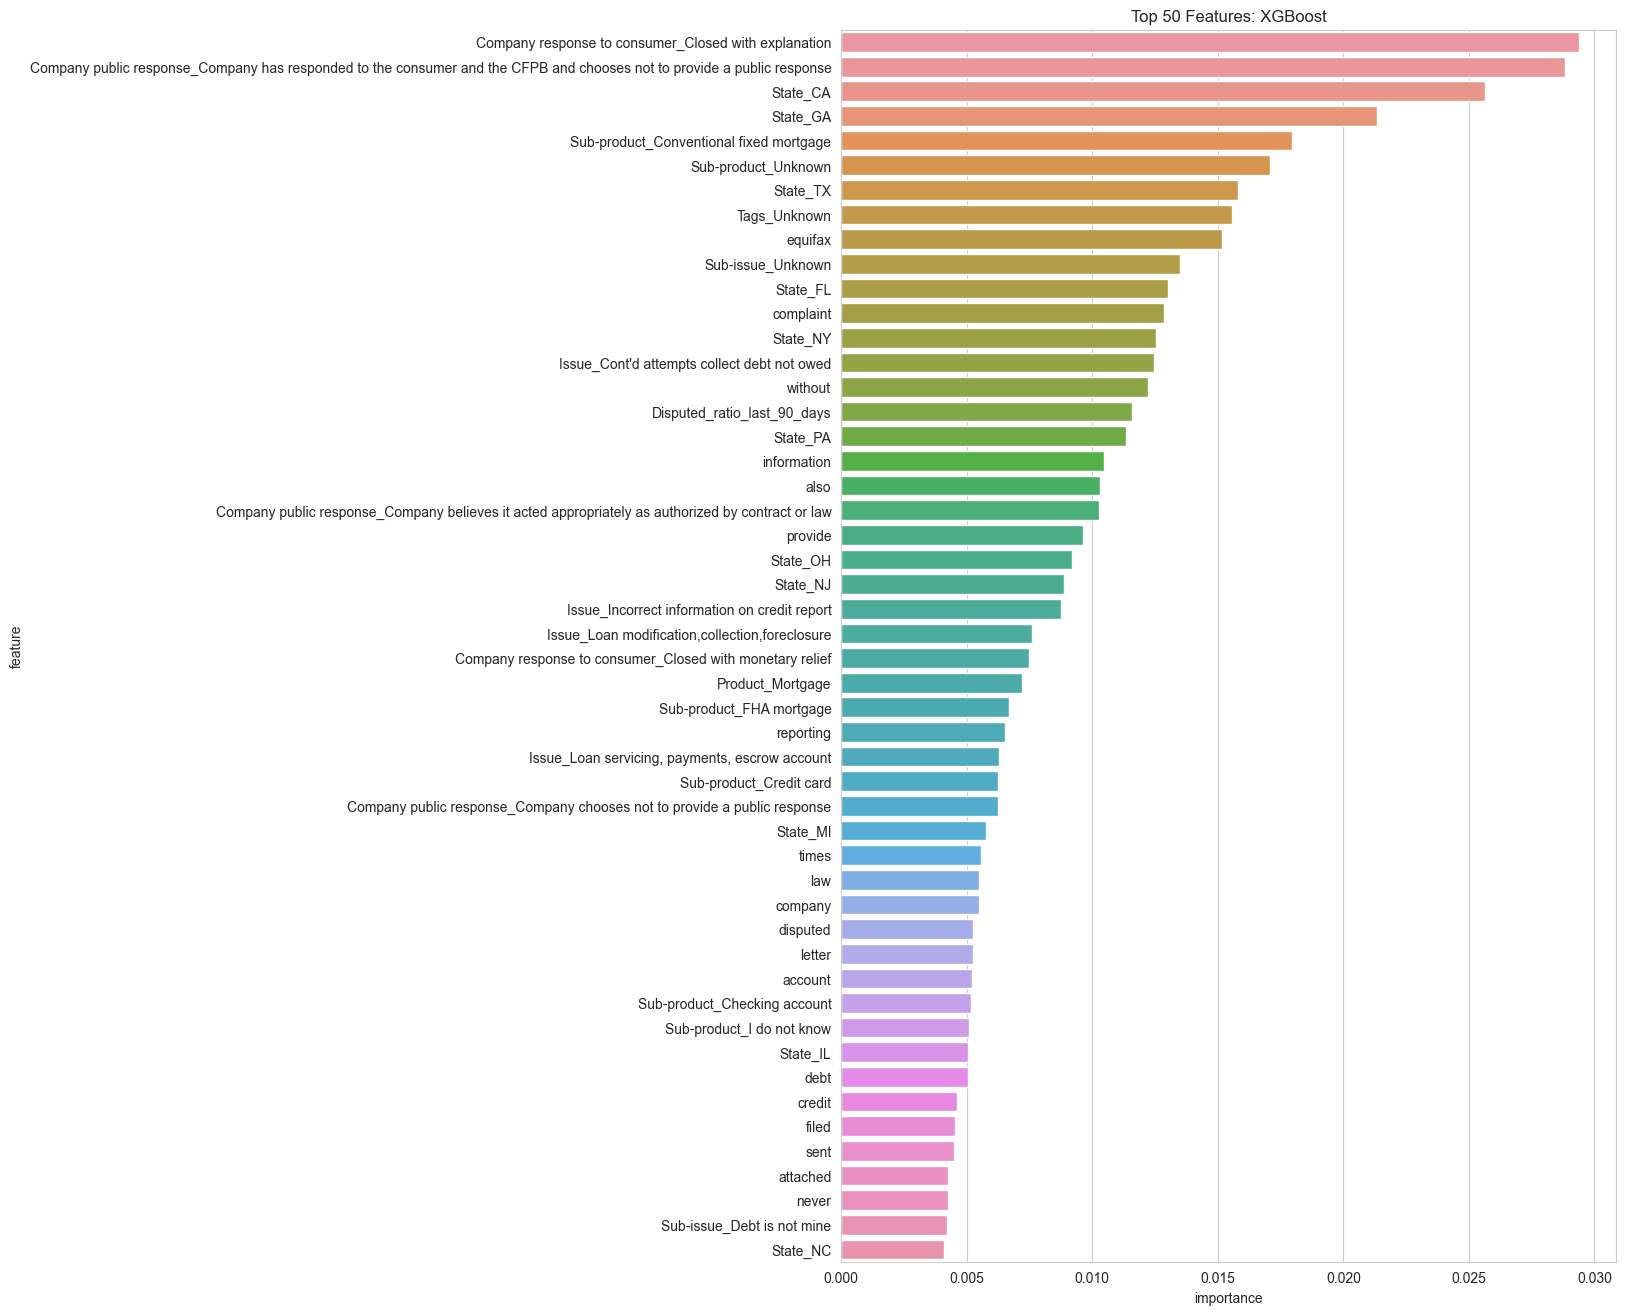

In [51]:
# feature importance of xgb
xgb_feature_importance = xgb.feature_importances_

# zip feature names and feature importance, and sort by feature importance in descending order
xgb_feature_importance = sorted(zip(feature_names, xgb_feature_importance), key=lambda x: x[1], reverse=True)

# plot top 50 features
xgb_feature_importance_df = pd.DataFrame(xgb_feature_importance[:50], columns=['feature', 'importance'])

# plot top 50 features with sns
plt.figure(figsize=(10, 16))
sns.barplot(x='importance', y='feature', data=xgb_feature_importance_df)
plt.title('Top 50 Features: XGBoost')
plt.show()


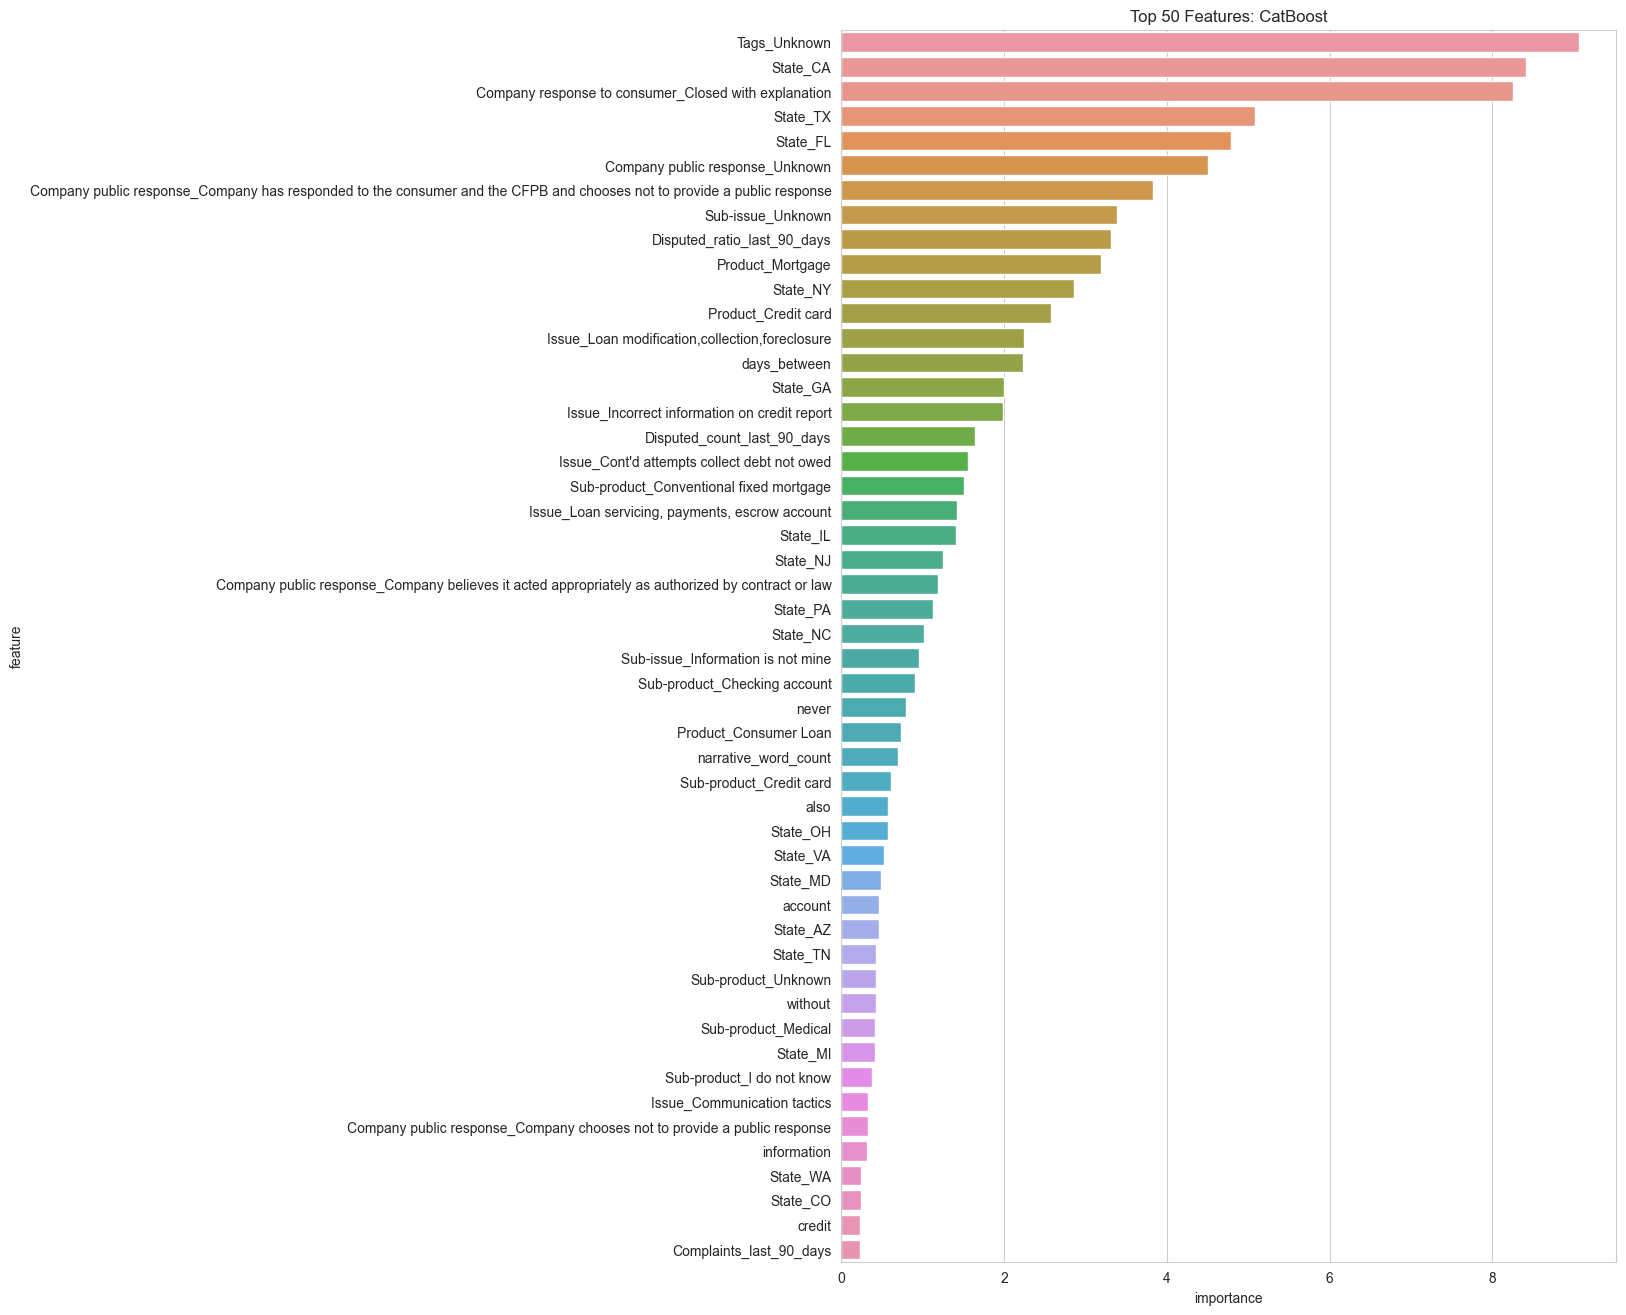

In [52]:
# feature importance of catboost
cat_feature_importance = cat.feature_importances_

# zip feature names and feature importance, and sort by feature importance in descending order
cat_feature_importance = sorted(zip(feature_names, cat_feature_importance), key=lambda x: x[1], reverse=True)

# plot top 50 features
cat_feature_importance_df = pd.DataFrame(cat_feature_importance[:50], columns=['feature', 'importance'])

# plot top 50 features with sns
plt.figure(figsize=(10, 16))

sns.barplot(x='importance', y='feature', data=cat_feature_importance_df)
plt.title('Top 50 Features: CatBoost')
plt.show()

In [62]:
# what are intersection of top 50 features of xgb and catboost?

xgb_top_50_features = set(xgb_feature_importance_df['feature'].values[:50])
cat_top_50_features = set(cat_feature_importance_df['feature'].values[:50])
intersection = xgb_top_50_features.intersection(cat_top_50_features)

print(f"Number of intersection features: {len(intersection)}")
print(f"Intersection features: {intersection}")

Number of intersection features: 34
Intersection features: {'account', 'Sub-product_Unknown', 'State_FL', 'also', 'State_NJ', 'information', 'Sub-product_I do not know', 'Company public response_Company has responded to the consumer and the CFPB and chooses not to provide a public response', 'Issue_Loan modification,collection,foreclosure', 'State_TX', 'without', 'never', 'State_OH', 'Sub-product_Conventional fixed mortgage', 'Company public response_Company believes it acted appropriately as authorized by contract or law', "Issue_Cont'd attempts collect debt not owed", 'Sub-product_Credit card', 'State_MI', 'Issue_Loan servicing, payments, escrow account', 'Product_Mortgage', 'State_CA', 'Sub-issue_Unknown', 'State_NY', 'Disputed_ratio_last_90_days', 'State_PA', 'credit', 'State_GA', 'Company response to consumer_Closed with explanation', 'Issue_Incorrect information on credit report', 'State_IL', 'State_NC', 'Sub-product_Checking account', 'Tags_Unknown', 'Company public response_Com

### Deep Learning

In [67]:
# train with fc

def train_evaluate_ann(X_train, y_train, X_test, y_test):

    # import tensorflow
    import tensorflow as tf
    
    # utilize cpu
    tf.config.set_visible_devices([], 'GPU')
    
    # print device
    print(f"Device: {tf.config.get_visible_devices()}")

    # set random seed
    tf.random.set_seed(42)

    NUM_CLASSES = 1

    # create model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4096, activation='relu', input_shape=(8435,)),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax' if NUM_CLASSES > 2 else 'sigmoid')
    ])

    # compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # fit model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1
    )

    # evaluate model
    model.evaluate(X_test, y_test)
    
    # predict on test data
    y_pred = model.predict(X_test)
    
    # print f1 score
    print("\nF1 Score: {:.4f}".format(f1_score(y_test, y_pred)))

    return model

In [68]:
# train and evaluate ANN

ann = train_evaluate_ann(X_train, y_train, X_test, y_test)

# todo in GPU mode



Device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Epoch 1/10
  56/6412 [..............................] - ETA: 37:44 - loss: 4.4139 - accuracy: 0.5195

KeyboardInterrupt: 